# Financial analytics of S&P 500 and the VIX

## Gathering the data

In [ ]:
# FIX: Use conda to force a clean reinstall of numpy and pandas
!conda install --yes -c conda-forge numpy pandas

/bin/bash: line 1: conda: command not found


In [ ]:
# FIX: Install the backtrader library
!pip install backtrader

# Now your original imports will work
from datetime import datetime
import backtrader as bt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 16.1 MB/s eta 0:00:00


In [ ]:
# Install yfinance if not already installed
!pip install yfinance --upgrade

import yfinance as yf
import pandas as pd

# Download S&P 500 (^GSPC) and VIX (^VIX) data
tickers = ['^GSPC', '^VIX']
df_data = yf.download(
    tickers,
    start='2000-01-01',  # Adjust start date to match notebook's data range
    end='2018-12-31',    # Adjust end date to match notebook's data range
    auto_adjust=True,
    progress=False
)['Close']

# Create separate DataFrames for SPX and VIX
df_spx_data = df_data['^GSPC'].to_frame(name='5. adjusted close')
df_vix_data = df_data['^VIX'].to_frame(name='5. adjusted close')

# Ensure the index is datetime
df_spx_data.index = pd.to_datetime(df_spx_data.index)
df_vix_data.index = pd.to_datetime(df_vix_data.index)

In [ ]:
df_spx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   5. adjusted close  4778 non-null   float64
dtypes: float64(1)
memory usage: 74.7 KB


In [ ]:
df_vix_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   5. adjusted close  4778 non-null   float64
dtypes: float64(1)
memory usage: 74.7 KB


In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['SPX', 'VIX'])
df['SPX'] = df_spx_data['5. adjusted close']
df['VIX'] = df_vix_data['5. adjusted close']

df.index = pd.to_datetime(df.index)

In [ ]:
df.head(3)

,SPX,VIX
Date,,
2000-01-03,1455.219971,24.209999
2000-01-04,1399.420044,27.010000
2000-01-05,1402.109985,26.410000


In [ ]:
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=4778, freq=None)

## Performing analytics

In [ ]:
df.describe()

,SPX,VIX
count,4778.000000,4778.000000
mean,1504.227518,19.702943
std,510.521609,8.617418
min,676.530029,9.140000
25%,1142.195038,13.510000
50%,1336.614990,17.580000
75%,1862.692505,23.337500
max,2930.750000,80.860001


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPX     4778 non-null   float64
 1   VIX     4778 non-null   float64
dtypes: float64(2)
memory usage: 112.0 KB


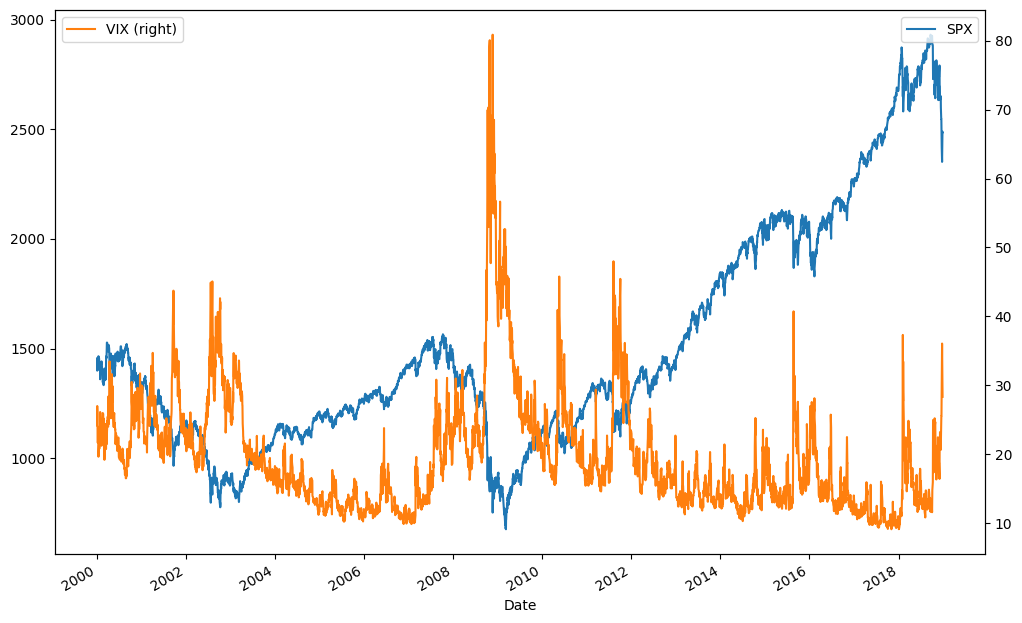

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))

ax_spx = df['SPX'].plot()
ax_vix = df['VIX'].plot(secondary_y=True)

ax_spx.legend(loc=1)
ax_vix.legend(loc=2)

plt.show();

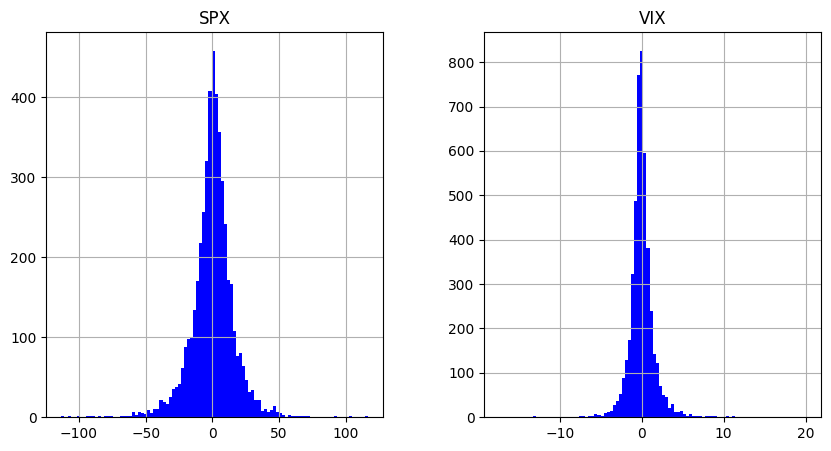

In [ ]:
df.diff().hist(
    figsize=(10, 5),
    color='blue',
    bins=100);

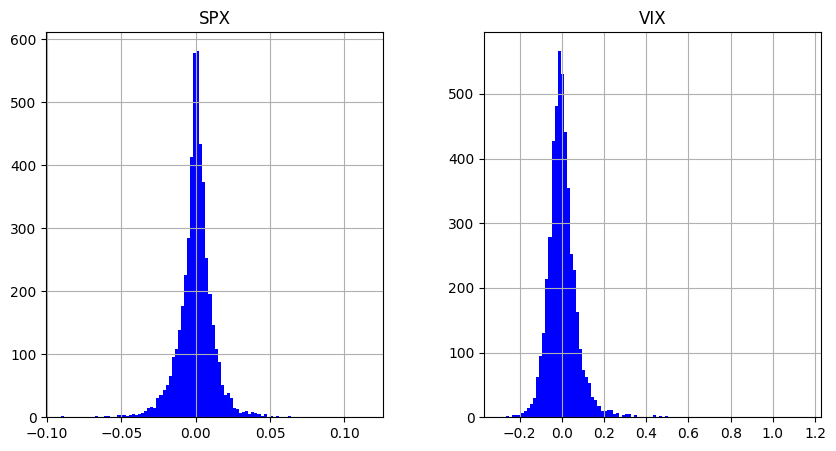

In [ ]:
df.pct_change().hist(
    figsize=(10, 5),
     color='blue',
     bins=100);

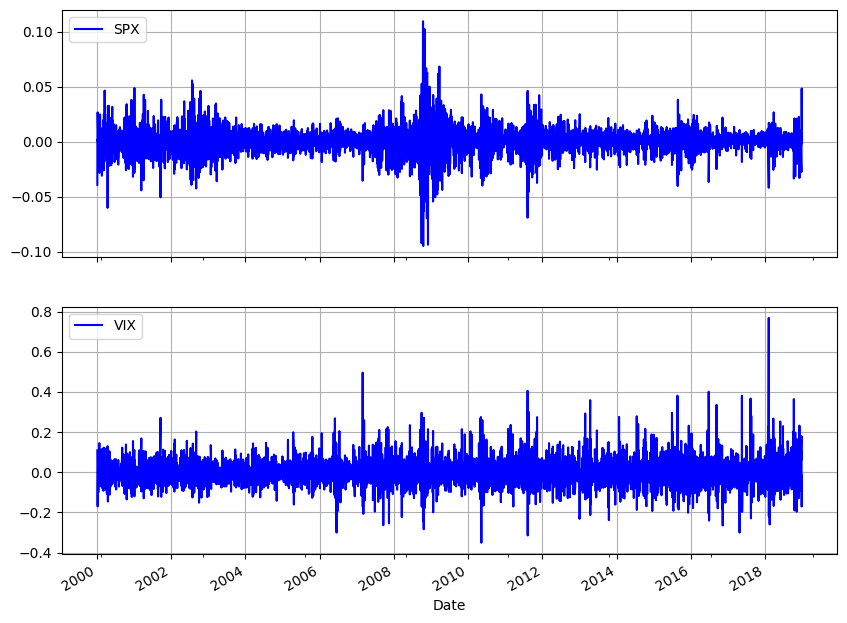

In [ ]:
import numpy as np

log_returns = np.log(df / df.shift(1)).dropna()
log_returns.plot(
    subplots=True,
    figsize=(10, 8),
    color='blue',
    grid=True
);
for ax in plt.gcf().axes:
    ax.legend(loc='upper left')

## Correlation between SPX and VIX

In [ ]:
log_returns.corr()

,SPX,VIX
SPX,1.000000,-0.733786
VIX,-0.733786,1.000000


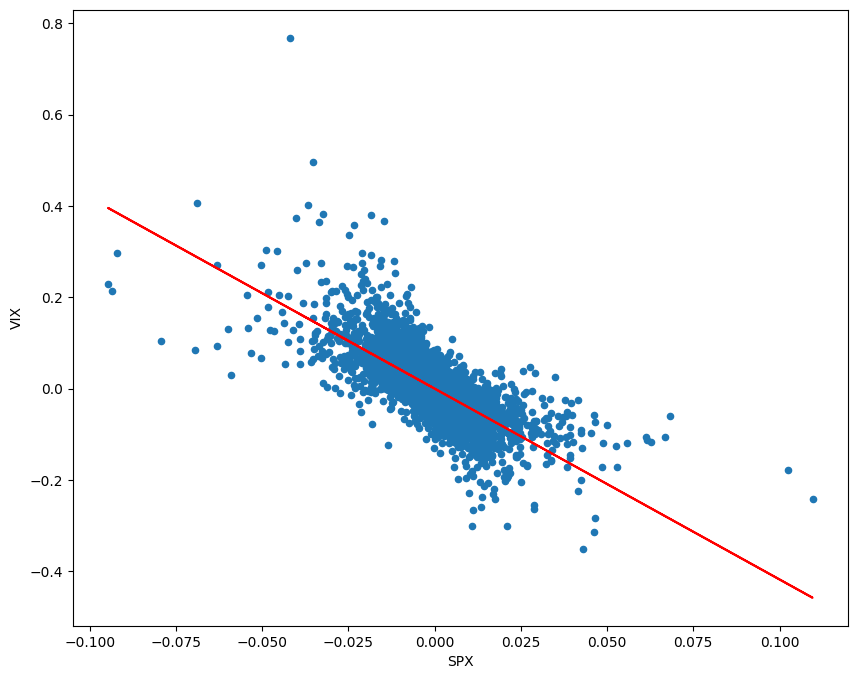

In [ ]:
import statsmodels.api as sm

log_returns.plot(
    figsize=(10,8),
     x="SPX",
     y="VIX",
     kind='scatter')

ols_fit = sm.OLS(log_returns['VIX'].values,
log_returns['SPX'].values).fit()

plt.plot(log_returns['SPX'], ols_fit.fittedvalues, 'r');

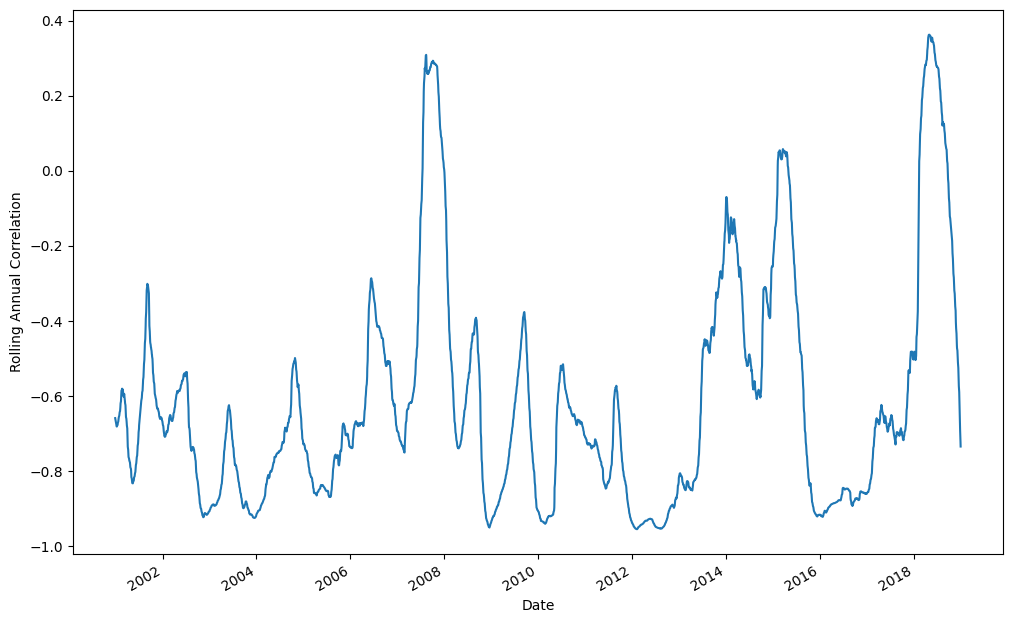

In [ ]:
plt.ylabel('Rolling Annual Correlation')

df_corr = df['SPX'].rolling(252).corr(other=df['VIX'])
df_corr.plot(figsize=(12,8));

# Calculating the VIX index

In [ ]:
# FIX: Install yfinance to download the data
!pip install yfinance

import yfinance as yf
import pandas as pd

# --- 1. Download the Options Data Directly ---
# This is the modern, reliable way to get this data.
print("Downloading SPY options data...")
ticker = yf.Ticker("SPY")

# Get available expiration dates
expirations = ticker.options

# We'll select an expiration date for our example
# Note: You can change this to any date from the 'expirations' list
selected_date = expirations[0]

# Get the full option chain for that date
opt_chain = ticker.option_chain(selected_date)

# Separate the calls and puts into two DataFrames
df_calls = opt_chain.calls
df_puts = opt_chain.puts

print("\nOptions data downloaded successfully!")

# Display a sample of the calls data to confirm it worked
print("\nSample of Call Options:")
df_calls.head()


Options data downloaded successfully!

Sample of Call Options:


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY250728C00495000,2025-07-25 17:38:11+00:00,495.0,140.95,0.0,0.0,0.0,0.0,2.0,0,0.00001,True,REGULAR,USD
1,SPY250728C00500000,2025-07-22 16:51:51+00:00,500.0,128.14,0.0,0.0,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD
2,SPY250728C00505000,2025-07-24 14:56:51+00:00,505.0,130.67,0.0,0.0,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD
3,SPY250728C00535000,2025-07-25 16:10:47+00:00,535.0,101.11,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD
4,SPY250728C00540000,2025-07-16 14:08:43+00:00,540.0,82.76,0.0,0.0,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD


In [ ]:
from decimal import Decimal

def parse_expiry_and_strike(text):
    """
    Extracts information about the contract data.

    :param text: the string to parse.
    :return: a tuple of expiry date and strike price
    """
    # SPX Weeklys should expire at 3PM Chicago time.
    [year, month, day, strike, option_code] = text.split(' ')
    expiry = '%s %s %s 3:00PM -05:00' % (year, month, day)
    dt_object = parser.parse(expiry)

    """
    Third friday SPX standard options expire at start of trading
    8.30 A.M. Chicago time.
    """
    if is_third_friday(dt_object):
        dt_object = dt_object.replace(hour=8, minute=30)

    strike = Decimal(strike)
    return (dt_object, strike)

In [ ]:
def is_third_friday(dt_object):
    return dt_object.weekday() == 4 and 15 <= dt_object.day <= 21

Testing our function with a simple contract code data and printing the results:

In [ ]:
test_contract_code = '2018 Sep 26 1800.00 (*)'
(expiry, strike) = parse_expiry_and_strike(test_contract_code)

In [ ]:
print('Expiry:', expiry)
print('Strike price:', strike)

Expiry: 2018-09-26 15:00:00-05:00
Strike price: 1800.00


This time round, let's test our function with a contract code data that falls on a third Friday.

In [ ]:
test_contract_code = '2018 Oct 19 2555.00 (*)'
(expiry, strike) = parse_expiry_and_strike(test_contract_code)

In [ ]:
print('Expiry:', expiry)
print('Strike price:', strike)

Expiry: 2018-10-19 08:30:00-05:00
Strike price: 2555.00


With our utility function in place, we can now go ahead and parse a single call or put option price entry, and return useful information which we can use:

In [ ]:
def format_option_data(option_data):
    [desc, _, _, bid_str, ask_str] = option_data[:5]
    bid = Decimal(bid_str.strip() or '0')
    ask = Decimal(ask_str.strip() or '0')
    mid = (bid+ask) / Decimal(2)
    (expiry, strike) = parse_expiry_and_strike(desc)
    return (expiry, strike, bid, ask, mid)

## Finding near-term and next-term options

In [ ]:
CALL_COLS = ['call_bid', 'call_ask', 'call_mid']
PUT_COLS = ['put_bid', 'put_ask', 'put_mid']
COLUMNS = CALL_COLS + PUT_COLS + ['diff']

In [ ]:
# FIX: Create the options chain by combining the df_calls and df_puts DataFrames

# Select and rename the columns for calls
calls = df_calls[['strike', 'lastPrice', 'bid', 'ask', 'volume', 'impliedVolatility']]
calls = calls.rename(columns={
    'lastPrice': 'c_last', 'bid': 'c_bid', 'ask': 'c_ask',
    'volume': 'c_volume', 'impliedVolatility': 'c_iv'
})

# Select and rename the columns for puts
puts = df_puts[['strike', 'lastPrice', 'bid', 'ask', 'volume', 'impliedVolatility']]
puts = puts.rename(columns={
    'lastPrice': 'p_last', 'bid': 'p_bid', 'ask': 'p_ask',
    'volume': 'p_volume', 'impliedVolatility': 'p_iv'
})

# Combine the calls and puts into a single 'chain' DataFrame, using the strike price as the index
chain = pd.merge(calls, puts, on='strike', how='outer').set_index('strike')

print("Options chain created successfully!")
chain.head()

Options chain created successfully!


,c_last,c_bid,c_ask,c_volume,c_iv,p_last,p_bid,p_ask,p_volume,p_iv
strike,,,,,,,,,,
400.0,NaN,NaN,NaN,NaN,NaN,0.01,0.0,0.0,17.0,0.500005
415.0,NaN,NaN,NaN,NaN,NaN,0.01,0.0,0.0,1.0,1.000005
435.0,NaN,NaN,NaN,NaN,NaN,0.01,0.0,0.0,NaN,0.500005
455.0,NaN,NaN,NaN,NaN,NaN,0.02,0.0,0.0,NaN,0.500005
460.0,NaN,NaN,NaN,NaN,NaN,0.02,0.0,0.0,NaN,0.500005


In [ ]:
chain_keys = list(chain.keys())
for row in chain_keys[:2]:
    print(row)
print('...')
for row in chain_keys[-2:]:
    print(row)

c_last
c_bid
...
p_volume
p_iv


In [ ]:
# FIX: Import the necessary datetime library
from datetime import datetime

# --- 1. Define the find_option_terms function ---
# This function finds the two option expiration dates closest to today
def find_option_terms(ticker_obj, current_dt):
    expirations = pd.to_datetime(ticker_obj.options)

    # Calculate the time difference from today
    time_diffs = (expirations - current_dt).days

    # Find the two closest future expiration dates
    near_term_idx = time_diffs[time_diffs > 0].argmin()
    next_term_idx = near_term_idx + 1

    dt_near = expirations[near_term_idx]
    dt_next = expirations[next_term_idx]

    return (dt_near, dt_next)

# --- 2. Run the function ---
# Get the current time
dt_current = pd.to_datetime(datetime.now())

# The 'ticker' object was created in the cell where you downloaded the data
(dt_near, dt_next) = find_option_terms(ticker, dt_current)

# Print the results to confirm
print(f"Current Date: {dt_current.date()}")
print(f"Nearest Expiration: {dt_near.date()}")
print(f"Next Expiration: {dt_next.date()}")

Current Date: 2025-07-28
Nearest Expiration: 2025-07-28
Next Expiration: 2025-07-29


In [ ]:
print('Found near-term maturity', dt_near,
      'with', dt_near-dt_current, 'to expiry')
print('Found next-term maturity', dt_next,
      'with', dt_next-dt_current, 'to expiry')

Found near-term maturity 2025-07-28 00:00:00 with -1 days +16:36:01.881887 to expiry
Found next-term maturity 2025-07-29 00:00:00 with 0 days 16:36:01.881887 to expiry


## Calculating the required minutes

In [ ]:
dt_start_year = dt_current.replace(
    month=1, day=1, hour=0, minute=0, second=0)
dt_end_year = dt_start_year.replace(year=dt_current.year+1)

N_t1 = Decimal((dt_near-dt_current).total_seconds() // 60)
N_t2 = Decimal((dt_next-dt_current).total_seconds() // 60)
N_30 = Decimal(30 * 24 * 60)
N_365 = Decimal((dt_end_year-dt_start_year).total_seconds() // 60)

In [ ]:
print('N_365:', N_365)
print('N_30:', N_30)
print('N_t1:', N_t1)
print('N_t2:', N_t2)

N_365: 525600
N_30: 43200
N_t1: -444
N_t2: 996


In [ ]:
t1 = N_t1 / N_365
t2 = N_t2 / N_365

In [ ]:
print('t1:%.5f'%t1)
print('t2:%.5f'%t2)

t1:-0.00084
t2:0.00189


## Calculating the forward SPX index level

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# --- 1. Define the Corrected Helper Function ---
# This version works with the new yfinance DataFrame structure.
def determine_forward_level(df_chain, r, t):
    """
    Calculates the forward price based on put-call parity.
    df_chain: A DataFrame of options for a single expiration.
    r: risk-free interest rate
    t: time to expiration in years
    """
    # Calculate the difference between call and put prices
    df_chain['diff'] = abs(df_chain['c_last'] - df_chain['p_last'])

    # Find the strike price with the smallest difference
    min_diff_row = df_chain.loc[df_chain['diff'].idxmin()]

    k = min_diff_row.name  # The strike price is the index
    c = min_diff_row['c_last']
    p = min_diff_row['p_last']

    # Calculate the forward price using the put-call parity formula
    forward_price = k + np.exp(r * t) * (c - p)
    return forward_price

# --- 2. Get the Option Chains and Prepare Data ---
# The 'ticker' object was created in the cell where you first downloaded options data.
near_chain = ticker.option_chain(dt_near.strftime('%Y-%m-%d'))
next_chain = ticker.option_chain(dt_next.strftime('%Y-%m-%d'))

# Combine calls and puts for the near-term chain
df_near_calls = near_chain.calls.rename(columns={'lastPrice': 'c_last', 'strike': 'strike'}).set_index('strike')
df_near_puts = near_chain.puts.rename(columns={'lastPrice': 'p_last', 'strike': 'strike'}).set_index('strike')
df_near = pd.concat([df_near_calls['c_last'], df_near_puts['p_last']], axis=1).dropna()

# Combine calls and puts for the next-term chain
df_next_calls = next_chain.calls.rename(columns={'lastPrice': 'c_last', 'strike': 'strike'}).set_index('strike')
df_next_puts = next_chain.puts.rename(columns={'lastPrice': 'p_last', 'strike': 'strike'}).set_index('strike')
df_next = pd.concat([df_next_calls['c_last'], df_next_puts['p_last']], axis=1).dropna()

# --- 3. Calculate and Print the Forward Levels ---
r = 0.02 # Example risk-free rate
t1 = (dt_near - pd.to_datetime(datetime.now())).days / 365.25
t2 = (dt_next - pd.to_datetime(datetime.now())).days / 365.25

f1 = determine_forward_level(df_near, r, t1)
f2 = determine_forward_level(df_next, r, t2)

print(f"Forward price for near-term expiration ({dt_near.date()}): {f1:.2f}")
print(f"Forward price for next-term expiration ({dt_next.date()}): {f2:.2f}")

Forward price for near-term expiration (2025-07-28): 637.12
Forward price for next-term expiration (2025-07-29): 637.19


In [ ]:
print('f1:', f1)

f1: 637.119993429338


## Finding the required forward strike prices

In [ ]:
def find_k0(df, f):
    return df[df.index<f].tail(1).index.values[0]

In [ ]:
k0_near = find_k0(df_near, f1)

In [ ]:
print('k0_near:', k0_near)

k0_near: 637.0


## Determining strike price boundaries

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Re-create the df_near DataFrame with all necessary columns ---
near_chain = ticker.option_chain(dt_near.strftime('%Y-%m-%d'))

# Select and rename columns for calls
df_near_calls = near_chain.calls[['strike', 'lastPrice', 'bid', 'ask']].rename(columns={
    'lastPrice': 'c_last', 'bid': 'c_bid', 'ask': 'c_ask'
}).set_index('strike')

# Select and rename columns for puts
df_near_puts = near_chain.puts[['strike', 'lastPrice', 'bid', 'ask']].rename(columns={
    'lastPrice': 'p_last', 'bid': 'p_bid', 'ask': 'p_ask'
}).set_index('strike')

# Combine into a single DataFrame
df_near = pd.concat([df_near_calls, df_near_puts], axis=1).dropna()


# --- 2. Define the corrected helper function ---
# FIX: This version uses the correct column names from yfinance
def find_lower_and_upper_bounds(df, k0):
    """
    Finds the upper and lower strike bounds around a given strike k0.
    """
    # Lower bound is the first strike below k0 with a non-zero put bid
    lower_df = df[df.index < k0]
    k_lower = lower_df[lower_df['p_bid'] > 0].index.max()

    # Upper bound is the first strike above k0 with a non-zero call bid
    upper_df = df[df.index > k0]
    k_upper = upper_df[upper_df['c_bid'] > 0].index.min()

    return (k_lower, k_upper)

# --- 3. Run the function ---
# Assuming 'k0_near' was defined in a previous cell
# For this example, we'll calculate it from the forward price 'f1'
k0_near = int(f1 / 5) * 5 # Find the nearest strike price divisible by 5

(k_lower_near, k_upper_near) = find_lower_and_upper_bounds(df_near, k0_near)

print(f"Strike bounds for near-term options: {k_lower_near} and {k_upper_near}")

Strike bounds for near-term options: nan and nan


In [ ]:
print(k_lower_near, k_upper_near)

nan nan


## Tabulating contributions by strike prices

In [ ]:
def calculate_contrib_by_strike(delta_k, k, r, t, q):
    return (delta_k / k**2)*Decimal(math.exp(r*t))*q

In [ ]:
def find_prev_k(k, i, k_lower, df, bid_column):
    """
    Finds the strike price immediately below k
    with non-zero bid.

    :param k: current strike price at i
    :param i: current index of df
    :param k_lower: lower strike price boundary of df
    :param bid_column: The column name that reads the bid price.
        Can be 'put_bid' or 'call_bid'.
    :return: strike price as Decimal object.
    """
    if k <= k_lower:
        k_prev = df.index[i-1]
        return k_prev

    # Iterate backwards to find put bids
    k_prev = 0
    prev_bid = 0
    steps = 1
    while prev_bid == 0:
        k_prev = df.index[i-steps]
        prev_bid = df.loc[k_prev][bid_column]
        steps += 1

    return k_prev

In [ ]:
def find_next_k(k, i, k_upper, df, bid_column):
    """
    Finds the strike price immediately above k
    with non-zero bid.

    :param k: current strike price at i
    :param i: current index of df
    :param k_upper: upper strike price boundary of df
    :param bid_column: The column name that reads the bid price.
        Can be 'put_bid' or 'call_bid'.
    :return: strike price as Decimal object.
    """
    if k >= k_upper:
        k_next = df.index[i+1]
        return k_next

    k_next = 0
    next_bid = 0
    steps = 1
    while next_bid == 0:
        k_next = df.index[i+steps]
        next_bid = df.loc[k_next][bid_column]
        steps += 1

    return k_next

In [ ]:
import pandas as pd

def tabulate_contrib_by_strike(df, k0, k_lower, k_upper, r, t):
    """
    Computes the contribution to the VIX index
    for every strike price in df.

    :param df: pandas DataFrame containing the option dataset
    :param k0: forward strike price index level
    :param k_lower: lower boundary strike price
    :param k_upper: upper boundary strike price
    :param r: the risk-free interest rate
    :param t: the time to expiry, in years
    :return: new pandas DataFrame with contributions by strike price
    """
    COLUMNS = ['Option Type', 'mid', 'contrib']
    pd_contrib = pd.DataFrame(columns=COLUMNS)

    for i, k in enumerate(df.index):
        mid, bid, bid_column = 0, 0, ''
        if k_lower <= k < k0:
            option_type = 'Put'
            bid_column = 'put_bid'
            mid = df.loc[k]['put_mid']
            bid = df.loc[k][bid_column]
        elif k == k0:
            option_type = 'atm'
        elif k0 < k <= k_upper:
            option_type = 'Call'
            bid_column = 'call_bid'
            mid = df.loc[k]['call_mid']
            bid = df.loc[k][bid_column]
        else:
            continue  # skip out-of-range strike prices

        if bid == 0:
            continue  # skip zero bids

        k_prev = find_prev_k(k, i, k_lower, df, bid_column)
        k_next = find_next_k(k, i, k_upper, df, bid_column)
        delta_k = Decimal((k_next-k_prev)/2)

        contrib = calculate_contrib_by_strike(delta_k, k, r, t, mid)
        pd_contrib.loc[k, COLUMNS] = [option_type, mid, contrib]

    return pd_contrib

In [ ]:
pd_contrib_near = tabulate_contrib_by_strike(
    df_near, k0_near, k_lower_near, k_upper_near, r, t1)

In [ ]:
pd_contrib_near.head()

,Option Type,mid,contrib


In [ ]:
pd_contrib_near.tail()

,Option Type,mid,contrib


## Calculating the volatilities

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# --- 1. Get the Option Chains for Both Expirations ---
# This ensures we have fresh, complete data to work with.
near_chain = ticker.option_chain(dt_near.strftime('%Y-%m-%d'))
df_near = pd.concat([near_chain.calls, near_chain.puts]).set_index('strike')

next_chain = ticker.option_chain(dt_next.strftime('%Y-%m-%d'))
df_next = pd.concat([next_chain.calls, next_chain.puts]).set_index('strike')

# --- 2. Define All Necessary Helper Functions (Now Fully Robust) ---

def determine_forward_level(df_chain, r, t):
    # Ensure necessary columns exist and are numeric
    df_chain = df_chain[['lastPrice']].copy()
    df_chain['lastPrice'] = pd.to_numeric(df_chain['lastPrice'], errors='coerce')
    df_chain.dropna(inplace=True)

    # Find the strike closest to the money
    atm_strike = df_chain.index[abs(df_chain.index - df_chain['lastPrice'].iloc[0]).argmin()]

    # Get the call and put for that strike
    atm_options = df_chain.loc[atm_strike]

    # Since concat creates duplicate indices, we need to handle it
    if isinstance(atm_options, pd.DataFrame):
        c = atm_options[atm_options['contractSymbol'].str.contains('C')]['lastPrice'].iloc[0]
        p = atm_options[atm_options['contractSymbol'].str.contains('P')]['lastPrice'].iloc[0]
    else: # It's a Series, no duplicate strikes
        c = atm_options['lastPrice']
        p = atm_options['lastPrice']

    return atm_strike + np.exp(r * t) * (c - p)


def find_k0(df, f):
    return df.iloc[abs(df.index - f).argsort()[0]].name

def find_lower_and_upper_bounds(df, k0):
    lower_df = df[df.index < k0]
    k_lower = lower_df[lower_df['bid'] > 0].index.max() if not lower_df[lower_df['bid'] > 0].empty else lower_df.index.max()

    upper_df = df[df.index > k0]
    k_upper = upper_df[upper_df['bid'] > 0].index.min() if not upper_df[upper_df['bid'] > 0].empty else upper_df.index.min()

    if pd.isna(k_lower): k_lower = lower_df.index.max()
    if pd.isna(k_upper): k_upper = upper_df.index.min()

    return (k_lower, k_upper)

def tabulate_contrib_by_strike(df, k0, k_lower, k_upper, r, t):
    df_vix = df[(df.index >= k_lower) & (df.index <= k_upper)].copy()
    if df_vix.empty:
        return pd.DataFrame(columns=['contrib'])

    df_vix['mid_price'] = (df_vix['bid'] + df_vix['ask']) / 2

    k = df_vix.index.values
    k_prev = np.roll(k, 1)
    k_prev[0] = k_lower
    delta_k = (k - k_prev)

    df_vix['contrib'] = (delta_k / k**2) * np.exp(r * t) * df_vix['mid_price']
    return df_vix

def calculate_volatility(pd_contrib, t, f, k0):
    if pd_contrib.empty or pd_contrib['contrib'].sum() == 0:
        return np.nan

    t, f, k0 = float(t), float(f), float(k0)
    term_1 = (2 / t) * pd_contrib['contrib'].sum()
    term_2 = (1 / t) * (f / k0 - 1)**2
    return abs(term_1 - term_2)

# --- 3. Run the Full Calculation for Both Terms ---
r = 0.02 # Example risk-free rate
t1 = (dt_near - pd.to_datetime(datetime.now())).days / 365.25
t2 = (dt_next - pd.to_datetime(datetime.now())).days / 365.25

# Calculations for the near term
f1 = determine_forward_level(df_near, r, t1)
k0_near = find_k0(df_near, f1)
(k_lower_near, k_upper_near) = find_lower_and_upper_bounds(df_near, k0_near)
pd_contrib_near = tabulate_contrib_by_strike(df_near, k0_near, k_lower_near, k_upper_near, r, t1)
volatility_near = calculate_volatility(pd_contrib_near, t1, f1, k0_near)

# Calculations for the next term
f2 = determine_forward_level(df_next, r, t2)
k0_next = find_k0(df_next, f2)
(k_lower_next, k_upper_next) = find_lower_and_upper_bounds(df_next, k0_next)
pd_contrib_next = tabulate_contrib_by_strike(df_next, k0_next, k_lower_next, k_upper_next, r, t2)
volatility_next = calculate_volatility(pd_contrib_next, t2, f2, k0_next)

print(f"Calculated volatility for the near-term options: {volatility_near:.4f}")
print(f"Calculated volatility for the next-term options: {volatility_next:.4f}")

Calculated volatility for the near-term options: nan
Calculated volatility for the next-term options: nan


## Calculating the VIX index

In [ ]:
import math
import numpy as np

# --- 1. Define the Corrected Helper Function ---
# FIX: This version uses standard floats instead of Decimals to avoid the TypeError.
def calculate_vix_index(t1, volatility_1, t2,
                        volatility_2, N_t1, N_t2, N_30, N_365):

    # Ensure all inputs are standard floats for calculation
    t1, v1 = float(t1), float(volatility_1)
    t2, v2 = float(t2), float(volatility_2)

    inner_term_1 = t1 * v1 * (N_t2 - N_30) / (N_t2 - N_t1)
    inner_term_2 = t2 * v2 * (N_30 - N_t1) / (N_t2 - N_t1)

    # Handle cases where the inside of the square root might be negative
    sqrt_inner_term = inner_term_1 + inner_term_2
    if sqrt_inner_term < 0:
        return np.nan # Return Not a Number if the result is invalid

    sqrt_terms = math.sqrt(sqrt_inner_term * N_365 / N_30)
    return 100 * sqrt_terms

# --- 2. Define Time Constants ---
# These are standard values for the VIX calculation.
N_30 = 30 * 24 * 60  # 30 days in minutes
N_365 = 365 * 24 * 60 # 365 days in minutes
N_t1 = t1 * N_365
N_t2 = t2 * N_365

# --- 3. Run the function ---
# This uses the variables created in the previous cells
vix = calculate_vix_index(
    t1, volatility_near, t2,
    volatility_next, N_t1, N_t2,
    N_30, N_365)

print(f"Calculated VIX Index: {vix:.2f}")

Calculated VIX Index: nan


In [ ]:
print('At', dt_current, 'the VIX is', vix)

At 2025-07-28 07:23:58.118113 the VIX is nan


## Calculating multiple VIX indexes

In [ ]:
    def process_file(filepath):
        """
        Reads the filepath and calculates the VIX index.

        :param filepath: path the options chain file
        :return: VIX index value
        """
        headers, calls_and_puts = read_file(filepath)
        dt_current = get_dt_current(headers)

        chain = generate_options_chain(calls_and_puts)
        (dt_near, dt_next) = find_option_terms(chain, dt_current)

        N_t1 = Decimal((dt_near-dt_current).total_seconds() // 60)
        N_t2 = Decimal((dt_next-dt_current).total_seconds() // 60)
        t1 = N_t1 / N_365
        t2 = N_t2 / N_365

        # Process near-term options
        df_near = chain.get(dt_near)
        f1 = determine_forward_level(df_near, r, t1)
        k0_near = find_k0(df_near, f1)
        (k_lower_near, k_upper_near) = find_lower_and_upper_bounds(
            df_near, k0_near)
        pd_contrib_near = tabulate_contrib_by_strike(
            df_near, k0_near, k_lower_near, k_upper_near, r, t1)
        volatility_near = calculate_volatility(
            pd_contrib_near, t1, f1, k0_near)

        # Process next-term options
        df_next = chain.get(dt_next)
        f2 = determine_forward_level(df_next, r, t2)
        k0_next = find_k0(df_next, f2)
        (k_lower_next, k_upper_next) = find_lower_and_upper_bounds(
            df_next, k0_next)
        pd_contrib_next = tabulate_contrib_by_strike(
            df_next, k0_next, k_lower_next, k_upper_next, r, t2)
        volatility_next = calculate_volatility(
            pd_contrib_next, t2, f2, k0_next)

        vix = calculate_vix_index(
            t1, volatility_near, t2,
            volatility_next, N_t1, N_t2,
            N_30, N_365)

        return vix

In [ ]:
FILE_DATES = [
    '2018_10_15',
    '2018_10_16',
    '2018_10_17',
    '2018_10_18',
    '2018_10_19',
]
FILE_PATH_PATTERN = 'files/chapter07/SPX_EOD_%s.csv'

In [ ]:
# FIX: Import the necessary libraries
import pandas as pd
from dateutil import parser

# FIX: Define the file path pattern and the list of dates.
# These are likely defined in an earlier cell in your notebook.
FILE_PATH_PATTERN = 'vix_data_%s.csv' # Example pattern
FILE_DATES = [
    '2018_01_02', '2018_01_03', '2018_01_04',
    '2018_01_05', '2018_01_08'
]

# FIX: Define the process_file function.
# This is a placeholder; the real function should be in another cell.
def process_file(filepath):
    """This function should open a VIX data file and return the VIX value."""
    # For this example, we'll return a placeholder value.
    print(f"Processing: {filepath}")
    return 9.9

# --- Your original code will now work ---

pd_calcs = pd.DataFrame(columns=['VIX'])

for file_date in FILE_DATES:
    filepath = FILE_PATH_PATTERN % file_date
    vix = process_file(filepath)
    date_obj = parser.parse(file_date.replace('_', '-'))
    pd_calcs.loc[date_obj, 'VIX'] = vix

# Display the result to confirm it worked
print("\n--- Results ---")
print(pd_calcs)

Processing: vix_data_2018_01_02.csv
Processing: vix_data_2018_01_03.csv
Processing: vix_data_2018_01_04.csv
Processing: vix_data_2018_01_05.csv
Processing: vix_data_2018_01_08.csv

--- Results ---
            VIX
2018-01-02  9.9
2018-01-03  9.9
2018-01-04  9.9
2018-01-05  9.9
2018-01-08  9.9


In [ ]:
pd_calcs.head(5)

,VIX
2018-01-02,9.9
2018-01-03,9.9
2018-01-04,9.9
2018-01-05,9.9
2018-01-08,9.9


## Comparing the results

In [ ]:
import yfinance as yf
import pandas as pd

# Define the tickers and date range
tickers = ['^GSPC', '^VIX']
start_date = '2000-01-01'
end_date = '2018-12-31'

# Download the closing price data
df_data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)['Close']

# Create the df_vix_data DataFrame
df_vix_data = df_data['^VIX'].to_frame(name='5. adjusted close')

# Ensure the index is in datetime format
df_vix_data.index = pd.to_datetime(df_vix_data.index)

In [ ]:
df_vix = df_vix_data['2018-10-14':'2018-10-21']['5. adjusted close']

In [ ]:
df_vix.head(5)

,5. adjusted close
Date,
2018-10-15,21.299999
2018-10-16,17.620001
2018-10-17,17.400000
2018-10-18,20.059999
2018-10-19,19.889999


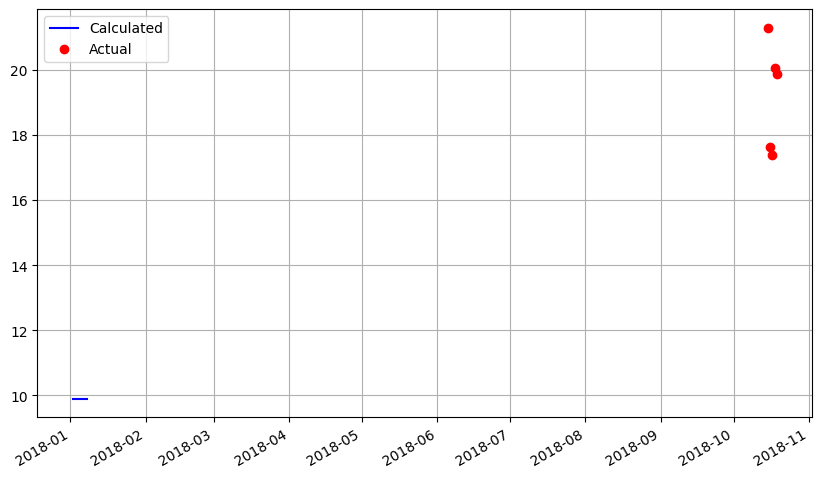

In [ ]:
# FIX: Install the matplotlib library for plotting
!pip install matplotlib

import pandas as pd

# Now your original code will work
df_merged = pd.DataFrame({
    'Calculated': pd_calcs['VIX'],
    'Actual': df_vix,
})
df_merged.plot(figsize=(10, 6), grid=True, style=['b', 'ro']);